In [83]:
import optuna
from optuna.samplers import TPESampler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import random
import matplotlib.pyplot as plt
import os
from joblib import dump

# CUDA
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE.type)

# Fix random seed
seed = 42
torch.manual_seed(seed)
if DEVICE.type == 'cuda':
	torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
sampler = TPESampler(seed=seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

optuna.logging.set_verbosity(optuna.logging.WARNING)

HYPERPARAMETERS_SEARCH = False

cuda


# Pre-processing input data

In [84]:
# train_df and test_df are created in eda notebook
if not os.path.exists('csv/train_df.csv') or not os.path.exists('csv/test_df.csv'):
	print('Please run the eda notebook first')
	exit()
train_df = pd.read_csv('csv/train_df.csv')
test_df = pd.read_csv('csv/test_df.csv')
target = 'total_time_target'
features = test_df.columns.copy().drop(target).drop(['benchmark','brand_raw', 'brand_raw_target','vendor_id_raw', 'arch'])

# Split data
X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

# Normalize data
x_scaler = MinMaxScaler(feature_range=(0, 1))
X_train = x_scaler.fit_transform(X_train)
X_test = x_scaler.transform(X_test)
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = y_scaler.transform(y_test.values.reshape(-1, 1))

# Convert to tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

if DEVICE.type == 'cuda':
	X_train = X_train.to(DEVICE)
	y_train = y_train.to(DEVICE)
	X_test = X_test.to(DEVICE)
	y_test = y_test.to(DEVICE)

In [85]:
if not os.path.exists('../models/x_scaler.joblib') or not os.path.exists('../models/y_scaler.joblib'):
	dump(x_scaler, '../models/x_scaler.joblib')
	dump(y_scaler, '../models/y_scaler.joblib')

# Model: Monte Carlo Dropout

In [86]:
class History:
	def __init__(self):
		self.loss = []
		self.val_loss = []
	
	def append(self, loss, val_loss):
		self.loss.append(loss)
		self.val_loss.append(val_loss)

def negative_log_likelihood(y, distribution):
    return -distribution.log_prob(y).mean()

def inv_scaling(y, y_scaler, d=False):
	if d:
		return y_scaler.inverse_transform(y.detach().cpu().numpy().reshape(-1, 1))
	return y_scaler.inverse_transform(y.cpu().numpy().reshape(-1, 1))

In [87]:
class MCDropoutModel(nn.Module):
	def __init__(self, input_dim, n_hidden_layers, dropout=0.1):
		super(MCDropoutModel, self).__init__()
		if n_hidden_layers < 2:
			raise ValueError("n_hidden_layers must be greater than 1")
		# Input layer
		layers = [
			nn.Linear(input_dim, 200),
			nn.ReLU(),
			nn.Dropout(p=dropout),
		]
		# Hidden layers
		layers.extend([
			nn.Linear(200, 500),
			nn.ReLU(),
			nn.Dropout(p=dropout)
		])
		for _ in range(n_hidden_layers-2):
			layers.extend([
				nn.Linear(500, 500),
				nn.ReLU(),
				nn.Dropout(p=dropout)
			])
		layers.extend([
			nn.Linear(500, 200),
			nn.ReLU(),
			nn.Dropout(p=dropout)
		])
		# Output layer
		layers.append(nn.Linear(200, 2))
		self.model = nn.Sequential(*layers)
	
	def forward(self, x):
		params = self.model(x)
		loc = params[:, 0:1]
		scale =  1e-6 + torch.nn.functional.softplus(0.33 * params[:, 1:2])
		return torch.distributions.Normal(loc, scale)
	
	def fit(self, X_train, y_train, X_test, y_test, epochs=100, batch_size=32, learning_rate=0.0002, verbose=True, patience=10):
		train_data = TensorDataset(X_train, y_train)
		test_data = TensorDataset(X_test, y_test)
		train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
		test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)
		
		best_val_loss = np.inf
		epoch_no_improve = 0
		best_model_state = None
		optimizer = optim.Adam(self.parameters(), lr=learning_rate)
		history = History()

		for epoch in range(epochs):
			self.train()
			total_loss = 0
			for batch_X, batch_y in train_loader:
				optimizer.zero_grad()
				distribution = self(batch_X)
				loss = negative_log_likelihood(batch_y, distribution)
				loss.backward()
				optimizer.step()
				total_loss += loss.item()
			avg_loss = total_loss / len(train_loader)
			
			self.eval()
			total_val_loss = 0
			with torch.no_grad():
				for batch_X, batch_y in test_loader:
					distribution = self(batch_X)
					val_loss = negative_log_likelihood(batch_y, distribution)
					total_val_loss += val_loss.item()
				avg_val_loss = total_val_loss / len(test_loader)
			
			if verbose:
				print(f"Epoch: {epoch+1} - Loss: {avg_loss} - Val Loss: {avg_val_loss}")

			# Early stopping
			if avg_val_loss < best_val_loss:
				best_val_loss = avg_val_loss
				best_model_state = self.state_dict()
				epoch_no_improve = 0
			else:
				epoch_no_improve += 1
				if epoch_no_improve >= patience:
					print(f"Early stopping at epoch {epoch+1}")
					break
			history.append(avg_loss, avg_val_loss)
		
		if best_model_state is not None:
			self.load_state_dict(best_model_state)
			
		return history

	def predict(self, X):
		self.eval()
		with torch.no_grad():
			predictions = self(X).sample()
		return predictions

# Hyperparameters Optimization

In [88]:
def objective(trial: optuna.Trial, X_train, y_train, X_test, y_test, y_scaler, input_dim):
	dropout = trial.suggest_float('dropout', 0.1, 0.5)
	n_hidden_layers = trial.suggest_int('n_hidden_layers', 2, 10)
	learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
	num_epochs = trial.suggest_int('num_epochs', 10, 100)

	# Model initialization 
	model = MCDropoutModel(input_dim, n_hidden_layers, dropout)
	if DEVICE.type == 'cuda':
		model = model.to(DEVICE)
	# Fit model
	history = model.fit(X_train, y_train, X_test, y_test, epochs=num_epochs, learning_rate=learning_rate)
	loss = history.loss[-1]
	val_loss = history.val_loss[-1]
	print(f"Trial: {trial.number} - NLL Loss: {loss} - NLL Val Loss: {val_loss} - epochs: {len(history.loss)}")
	return val_loss.item()

n_trials = 250
study = None

In [89]:
if HYPERPARAMETERS_SEARCH:
	study = optuna.create_study(direction='minimize', sampler=sampler)
	study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test, y_scaler, len(features)), n_trials=n_trials)

In [90]:
if study is not None:
	print(f'Number of trials: {len(study.trials)}')
	trial = study.best_trial
	print(f'Best trial: {trial.number}')
	print(f'Best params: {trial.params}')
	print(f'Best validation loss: {y_scaler.inverse_transform(np.reshape(trial.value, (-1,1))).item()}')

# Training

In [91]:
# Hyperparameters
if study is not None:
	dropout = study.best_trial.params['dropout']
	n_hidden_layers = study.best_trial.params['n_hidden_layers']
	lr = study.best_trial.params['learning_rate']
	num_epochs = study.best_trial.params['num_epochs']
else:
	dropout = 0.1
	n_hidden_layers = 3
	lr = 0.0002
	num_epochs = 100

In [92]:
# Model initialization 
model = MCDropoutModel(len(features), n_hidden_layers, dropout)
if DEVICE.type == 'cuda':
	model = model.to(DEVICE)
# Fit model
history = model.fit(X_train, y_train, X_test, y_test, epochs=num_epochs, learning_rate=lr)
loss = history.loss[-1]
val_loss = history.val_loss[-1]

Epoch: 1 - Loss: -2.0983769228421596 - Val Loss: -3.017061178008886
Epoch: 2 - Loss: -2.9372529872770814 - Val Loss: -3.4709570602286015
Epoch: 3 - Loss: -3.2788089616617686 - Val Loss: -2.7633307926644584
Epoch: 4 - Loss: -3.570153953065593 - Val Loss: -3.736972229163534
Epoch: 5 - Loss: -3.6163738246922374 - Val Loss: -3.6366511214956194
Epoch: 6 - Loss: -3.614243571768603 - Val Loss: -4.11625552669871
Epoch: 7 - Loss: -3.9496966604292716 - Val Loss: -4.3207831969524655
Epoch: 8 - Loss: -3.8871248286310283 - Val Loss: -4.260960607569617
Epoch: 9 - Loss: -4.00513062575269 - Val Loss: -4.50828345906581
Epoch: 10 - Loss: -4.136806383615971 - Val Loss: -4.167662166730529
Epoch: 11 - Loss: -4.016363375139133 - Val Loss: -4.430144449927776
Epoch: 12 - Loss: -4.080691958679732 - Val Loss: -4.115182758400881
Epoch: 13 - Loss: -4.2769236371227874 - Val Loss: -4.433556528690035
Epoch: 14 - Loss: -4.2561472913296745 - Val Loss: -4.449322211640076
Epoch: 15 - Loss: -4.376649594578169 - Val Loss:

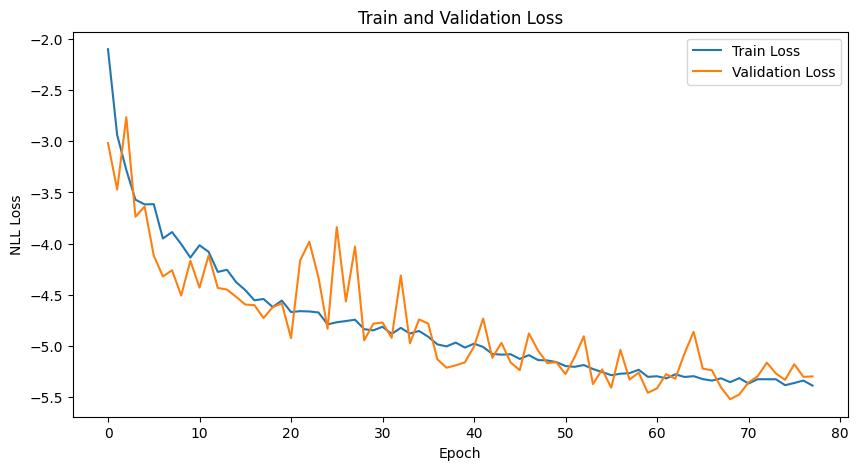

In [93]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history.loss, label='Train Loss')
plt.plot(history.val_loss, label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('NLL Loss')
plt.legend()
plt.show()

In [94]:
# Save model
torch.save(model, '../models/mc_dropout_model.pt')

# Describe Validation

In [95]:
model = torch.load('../models/mc_dropout_model.pt').to(DEVICE)

In [96]:
def describe_val(model, X, y, y_scaler):
	min_instance = {"prediction": float('inf'), "actual": 0, "index": 0}
	max_instance = {"prediction": 0, "actual": 0, "index": 0}
	predictions = model.predict(X)
	predictions = inv_scaling(predictions, y_scaler)
	y_scaled = inv_scaling(y, y_scaler)
	index_min = np.argmin(np.abs(predictions - y_scaled))
	min_instance["prediction"] = predictions[index_min].item()
	min_instance["actual"] = y_scaled[index_min].item()
	min_instance["index"] = index_min
	index_max = np.argmax(np.abs(predictions - y_scaled))
	max_instance["prediction"] = predictions[index_max].item()
	max_instance["actual"] = y_scaled[index_max].item()
	max_instance["index"] = index_max

	return min_instance, max_instance, predictions

In [101]:
print("Validation set single thread model")
min_instance, max_instance, predictions = describe_val(model, X_test, y_test, y_scaler)
y_scaled = inv_scaling(y_test, y_scaler)
errors = np.abs(predictions - y_scaled)
mean_error = np.mean(errors)
std_error = np.std(errors)

print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(y_scaled)} | Std actual: {np.std(y_scaled)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("Min instance")
print(test_df.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(test_df.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set single thread model
Mean prediction: 21.614517211914062 | Std actual: 38.052940368652344
Mean actual: 23.40154457092285 | Std actual: 44.03072738647461
Mean Error: 2.7817482948303223 | Std Error: 9.08431625366211
Min instance
total_time                                                            1.17
total_cpu_usage                                                       0.99
max_ram_usage                                                    26.558594
brand_raw                         Intel(R) Core(TM) i5-10400 CPU @ 2.90GHz
vendor_id_raw                                                 GenuineIntel
arch                                                                X86_64
count                                                                   12
l2_cache_size                                                          1.5
l3_cache_size                                                         12.0
l2_cache_line_size                                                     256
l2_cache_